---
# Introduction
---

DLinear is just a fully connected with the Autoformer's **DecompositionLayer**. The DLinear model first decomposes a raw data input into a trend component by a moving average kernel and a remainder (seasonal) component. Then, two one-layer linear layers are applied to each component, and we sum up the two features to get the final prediction.

### Decomposition layer 
The decomposition scheme used in DLinear is a combination of the one used in Autoformer and FEDformer.


<img width="800" src="https://www.researchgate.net/publication/360888216/figure/fig2/AS:1160187520004104@1653621668476/Illustration-of-the-Decomposition-Linear-Model.png" alt="Informer Architecture" />


---
## Inputs and Outputs
---
##### **Input sequence:**
The input of a DLinear model is a raw data input, which is a sequence of observations recorded at regular intervals over time. the input sequence directly feed to the decomposition linear model.


- The length of the input sequence is defined by the seq_len hyperparameter.

##### **Output sequence:**
The output of a DLinear model is the final prediction, which is obtained by summing up the two features extracted from the trend and seasonal components of the input data. The two features are obtained by applying two one-layer linear layers to each component.

- The length of the output sequence is defined by the pred_len hyperparameter.


---
## Methodology
---
This notebook provide a step-by-step guide for replicating the **Dlinear** model and training it on the ETDataset (ETTh1, ETTh2, ETTm1, and ETTm2), ensuring accurate reproduction of the models by comparing the notebook results with the official paper results. The workflow from the beginning to forcasting is as follows:

### 1. Data Decomposition
The raw data input is decomposed into a trend component and a remainder (seasonal) component using a moving average kernel. This step is performed to handle time series data with a clear trend.
### 2. Linear Layers
Two one-layer linear layers are applied to each component to extract two features.
### 3. Feature Summation
The two features extracted from the trend and seasonal components are summed up to get the final prediction.

---
## Hyperparameters
---

**Some of the hyperparameters control the input and output of the mode**

1. `args.features`: The forecasting task, options: [M, S, MS]; M: multivariate predict multivariate, 2: univariate predict univariate, MS: multivariate predict univariate
3. `args.target`: The target feature in S or MS task
4. `args.enc_in`: The size of the encoder input
5. `args.dec_in`: The size of the decoder input
6. `args.c_out`: The output size of the decoder
7. `args.batch_size`: The batch size used during training and inference

-----------

**hyperparameters  for controlling the sequence lengths:**

1. `args.seq_len`: The length of the input sequence of the DLinear encoder.
2. `args.pred_len`: The length of the output sequence to be predicted by the model.
3. `args.label_len`: The length of the start token series used as input to the DLinear decoder.

-----------

**hyperparameters for controlling the architecture and training process:**

1. `args.d_model`: The dimension of the model.
2. `args.n_heads`: The number of attention heads in the model.
3. `args.e_layers`: The number of layers in the encoder.
4. `args.d_layers`: The number of layers in the decoder.
5. `args.d_ff`: The dimension of the feedforward layer in the model.
6. `args.dropout`: The dropout rate.
7. `args.attn`: The type of attention used in the encoder, options: [prob, full].
8. `args.embed`: The type of time features encoding, options: [timeF, fixed, learned].
9. `args.activation`: The activation function used in the model.
10. `args.distil`: Whether to use distilling in the encoder.
11. `args.loss`: The loss function used during training.
12. `args.learning_rate`: The learning rate used during training.
13. `args.train_epochs`: The number of epochs to train the model.
14. `args.patience`: The number of epochs to wait before early stopping if the validation loss does not improve.
15. `args.use_amp`: Whether to use automatic mixed precision training.

**hyperparameters with their descriptions for controlling other aspects of the DLinear model:**

1. `args.output_attention`: Whether to output attention in the encoder.
2. `args.checkpoints`: The location of model checkpoints.
3. `args.num_workers`: The number of workers used for data loading.
4. `args.gpu`: The GPU index to use for training and inference.
5. `args.devices`: The indices of the GPUs to use for multi-GPU training.

Note that these hyperparameters control other aspects of the DLinear model, such as debugging, data loading, and GPU settings, and can be adjusted based on the specific requirements of the experiment.

---
# Setup
---

In [17]:
!git clone https://github.com/debi2023-group3/Transformer-based-solutions-for-the-long-term-time-series-forecasting.git

Cloning into 'Transformer-based-solutions-for-the-long-term-time-series-forecasting'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 196 (delta 77), reused 165 (delta 46), pack-reused 0
Receiving objects: 100% (196/196), 33.18 MiB | 23.17 MiB/s, done.
Resolving deltas: 100% (77/77), done.


**Add project_files to system path**

In [18]:
import os
os.chdir('/kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting')

In [19]:
import sys
if not 'Transformer-based-solutions-for-the-long-term-time-series-forecasting' in sys.path:
    sys.path += ['Transformer-based-solutions-for-the-long-term-time-series-forecasting']
    
sys.path

['/kaggle/working',
 '/kaggle/lib/kagglegym',
 '/kaggle/lib',
 '/opt/conda/lib/python310.zip',
 '/opt/conda/lib/python3.10',
 '/opt/conda/lib/python3.10/lib-dynload',
 '',
 '/root/.local/lib/python3.10/site-packages',
 '/opt/conda/lib/python3.10/site-packages',
 '/src/bq-helper',
 'Transformer-based-solutions-for-the-long-term-time-series-forecasting']

**Important library**

In [20]:
import torch
%matplotlib inline

from exp.exp_DLinear import Exp_Main #, Dataset_Pred

In [21]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
"""
    **dotdict function**
    This function is used to convert a dictionary into
    an object whose keys can be accessed as attributes
"""

args = dotdict()

**GPU Device Hyperparameters**

In [22]:
######################### Device Hyperparameters  ##########################
args.use_multi_gpu = False
args.num_workers = 0
args.use_gpu = torch.cuda.is_available() 
args.gpu = 0                           # The index of the GPU to use.

**Dataset Hyperparameters**

In [23]:
######################### Dataset Hyperparameters  ##########################
args.data = 'ETTh1'            # dataset name
args.root_path = './Datasets/' # root path of data file
args.data_path = 'ETTh1.csv'   # data file
args.features = 'M'            # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT'             # target feature in S or MS task
args.freq = 'h'                # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.embed = 'timeF'           # time features (date) encoding, options:[timeF, fixed, learned]
args.padding = 0               # the amount of padding to add to the input sequence of the Informer model

**Experiment Hyperparameters**



In [24]:
######################### Experiment Hyperparameters  ##########################

# args.output_attention = False # whether to output attention in ecoder
args.train_only = True
args.train_epochs = 30        # The number of epochs to train for.
args.batch_size = 32          # The batch size of training input data.
args.learning_rate = 0.05     # learning rate starts from 1e−4, decaying two times smaller every epoch.
args.lradj = 'type1'          # learning rate decayed two times smaller every epoch.
args.loss = 'mse'             # evaluating criteria
args.patience = 3             # The number of epochs to wait before early stopping.
args.des = 'Exp'              # The description of the experiment.
args.itr  = 1

args.model = 'DLinear' 
args.checkpoints = './Checkpoints/DLinear_checkpoints' # location of model checkpoints

**Modeling Hyperparameters**

In [25]:
args.enc_in = 7 
args.label_len = 48
args.seq_len = 336              # input sequence length of DLinear encoder
args.pred_len = 96              # prediction sequence length

---
# Working on ETTh1 Dataset
---

## Trail 1: DLinear, Dataset:ETTh1,  Prediction Length: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [26]:
setting=f'{args.model}_train_on_{args.data}_{args.pred_len}_test'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh1_96_test:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 96}


### Training

In [27]:
# set experiments
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8209
                                   Training                               
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 256 	 Train Loss: 3.0598322
     Validation loss decreased (inf --> 3.059832).  Saving model ...
Updating learning rate to 0.05
                                   Epoch 2 Summery                          
--------------------------------------------------------------------------------
     Cost time: 2
     Steps: 256 	 Train Loss: 0.5542165
     Validation loss decreased (3.059832 --> 0.554217).  Saving model ...
Updating learning rate to 0.025
                                   Epoch 3 Summery                          
--------------------------------------------------------------------------------
     Cost time: 3
     Steps: 256 	 Train Loss: 0.4384580
     Validation loss decreased (0.554217 -->

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=96, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=96, bias=True)
)

### Testing

test 2785
mae:0.39157673716545105, mse:0.3703197240829468, rmse:0.6085389852523804, mape:8.982672691345215, mspe:34965.15234375


<Figure size 1500x500 with 0 Axes>

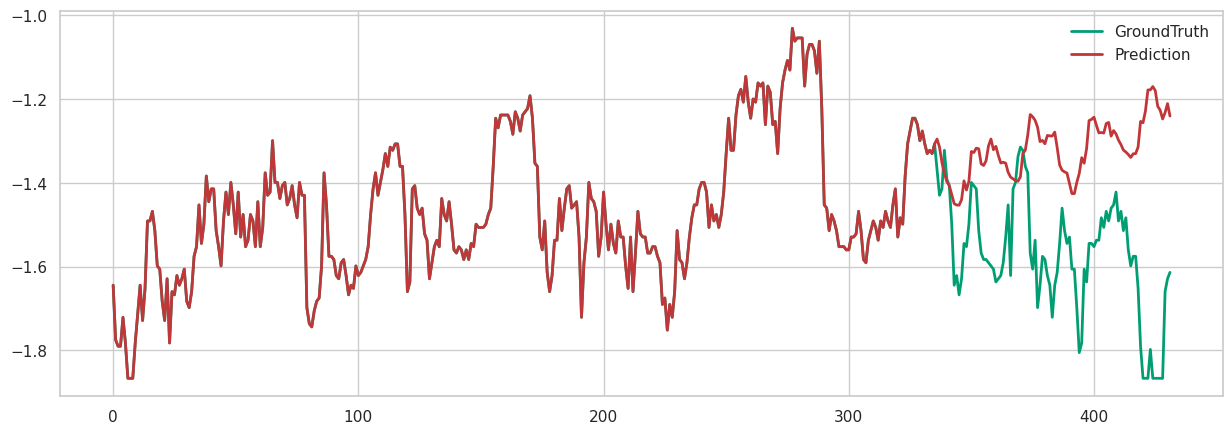

In [28]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 2: DLinear, Dataset:ETTh1 , Prediction Length: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary

In [29]:
args.pred_len = 192 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh1_192:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 192}


### Training

In [30]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8113
                                   Training                               
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 253 	 Train Loss: 2.5264609
     Validation loss decreased (inf --> 2.526461).  Saving model ...
Updating learning rate to 0.05
                                   Epoch 2 Summery                          
--------------------------------------------------------------------------------
     Cost time: 2
     Steps: 253 	 Train Loss: 0.6353627
     Validation loss decreased (2.526461 --> 0.635363).  Saving model ...
Updating learning rate to 0.025
                                   Epoch 3 Summery                          
--------------------------------------------------------------------------------
     Cost time: 3
     Steps: 253 	 Train Loss: 0.5023371
     Validation loss decreased (0.635363 -->

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=192, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=192, bias=True)
)

### Testing

test 2689
mae:0.41284340620040894, mse:0.4043136537075043, rmse:0.6358566284179688, mape:8.631369590759277, mspe:31306.4296875


<Figure size 1500x500 with 0 Axes>

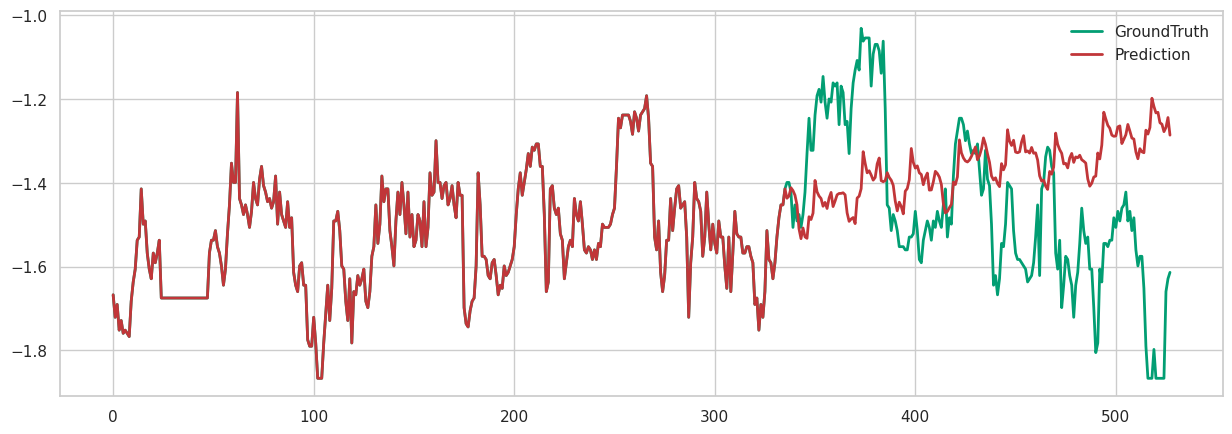

In [31]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 3: DLinear, Dataset:ETTh1,  Prediction Length: 336

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [32]:
args.pred_len = 336 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh1_336:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 336}


### Training

In [33]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7969
                                   Training                               
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 249 	 Train Loss: 3.5481750
     Validation loss decreased (inf --> 3.548175).  Saving model ...
Updating learning rate to 0.05
                                   Epoch 2 Summery                          
--------------------------------------------------------------------------------
     Cost time: 2
     Steps: 249 	 Train Loss: 0.6853783
     Validation loss decreased (3.548175 --> 0.685378).  Saving model ...
Updating learning rate to 0.025
                                   Epoch 3 Summery                          
--------------------------------------------------------------------------------
     Cost time: 3
     Steps: 249 	 Train Loss: 0.5574609
     Validation loss decreased (0.685378 -->

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=336, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=336, bias=True)
)

### Testing

test 2545
mae:0.43429017066955566, mse:0.43358343839645386, rmse:0.6584705114364624, mape:8.530790328979492, mspe:29368.431640625


<Figure size 1500x500 with 0 Axes>

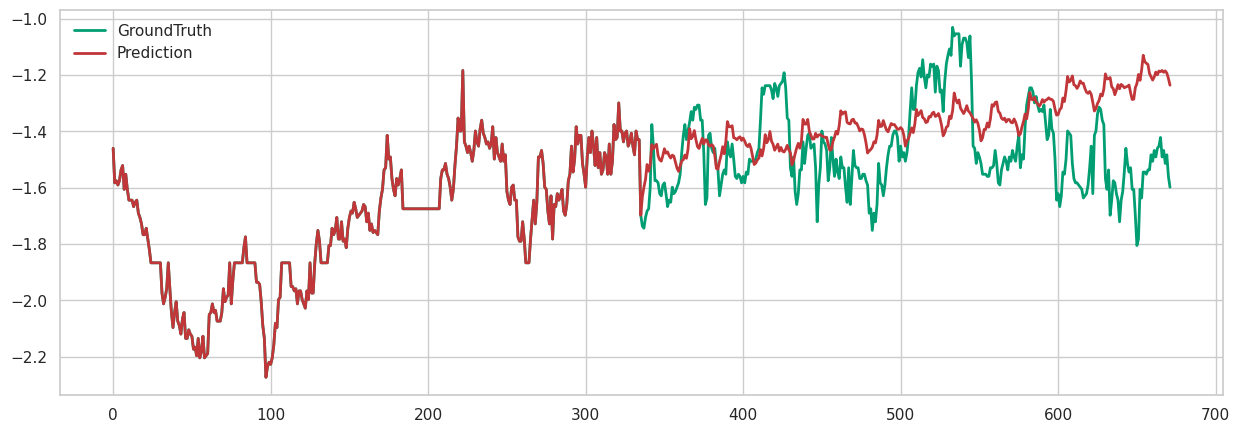

In [34]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 4: DLinear, Dataset:ETTh1,  Prediction Length: 720

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [35]:
args.pred_len = 720 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh1_720:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 720}


### Training

In [36]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7585
                                   Training                               
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 237 	 Train Loss: 3.9322428
     Validation loss decreased (inf --> 3.932243).  Saving model ...
Updating learning rate to 0.05
                                   Epoch 2 Summery                          
--------------------------------------------------------------------------------
     Cost time: 2
     Steps: 237 	 Train Loss: 0.7859597
     Validation loss decreased (3.932243 --> 0.785960).  Saving model ...
Updating learning rate to 0.025
                                   Epoch 3 Summery                          
--------------------------------------------------------------------------------
     Cost time: 3
     Steps: 237 	 Train Loss: 0.6344823
     Validation loss decreased (0.785960 -->

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=720, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=720, bias=True)
)

### Testing

test 2161
mae:0.4878787696361542, mse:0.4716416597366333, rmse:0.686761736869812, mape:9.447455406188965, mspe:32937.5625


<Figure size 1500x500 with 0 Axes>

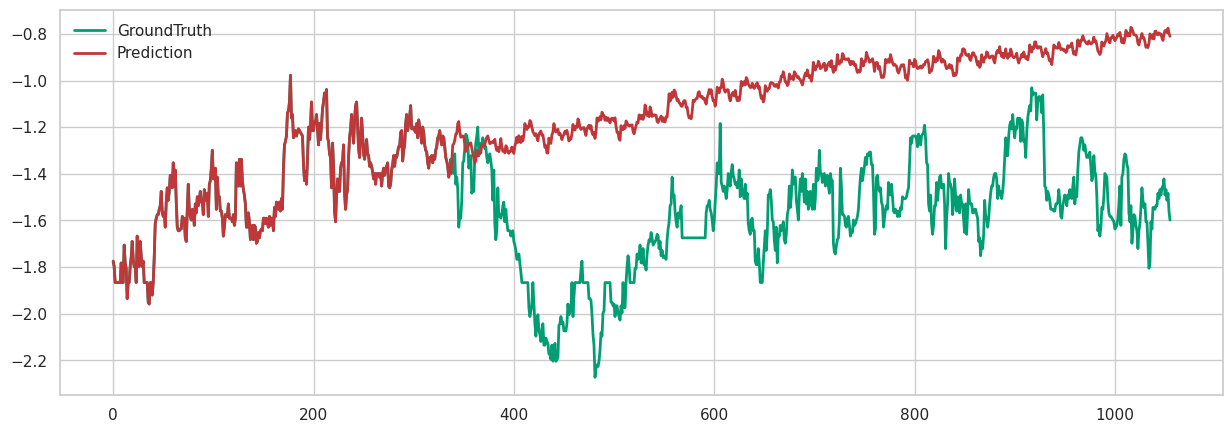

In [37]:
exp.test(setting)
torch.cuda.empty_cache()

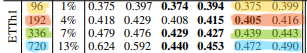

In [38]:
from IPython.display import Image
Image(filename=r"./Images/ETT1.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 |  0.37019482254981995| 0.3915349543094635  |
| 192 |  0.40499380230903625 | 0.4138428270816803 |
| 336 | 0.4337225556373596 | 0.434622198343277  |
| 720 | 0.470274418592453| 0.4867483675479889 |


---
# Working on ETTh2 Dataset
---

## Trail 1: DLinear, Dataset:ETTh2,  Prediction Length: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [39]:
args.data_path = 'ETTh2.csv' # data file
args.data = 'ETTh2'  # data
args.pred_len = 96 # prediction sequence length

setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh2_96:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 96}


### Training

In [40]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8209
                                   Training                               
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 256 	 Train Loss: 3.1055429
     Validation loss decreased (inf --> 3.105543).  Saving model ...
Updating learning rate to 0.05
                                   Epoch 2 Summery                          
--------------------------------------------------------------------------------
     Cost time: 2
     Steps: 256 	 Train Loss: 0.7035208
     Validation loss decreased (3.105543 --> 0.703521).  Saving model ...
Updating learning rate to 0.025
                                   Epoch 3 Summery                          
--------------------------------------------------------------------------------
     Cost time: 3
     Steps: 256 	 Train Loss: 0.5481766
     Validation loss decreased (0.703521 -->

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=96, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=96, bias=True)
)

### Testing

test 2785
mae:0.36563724279403687, mse:0.302042692899704, rmse:0.5495840907096863, mape:1.2717113494873047, mspe:288.4268493652344


<Figure size 1500x500 with 0 Axes>

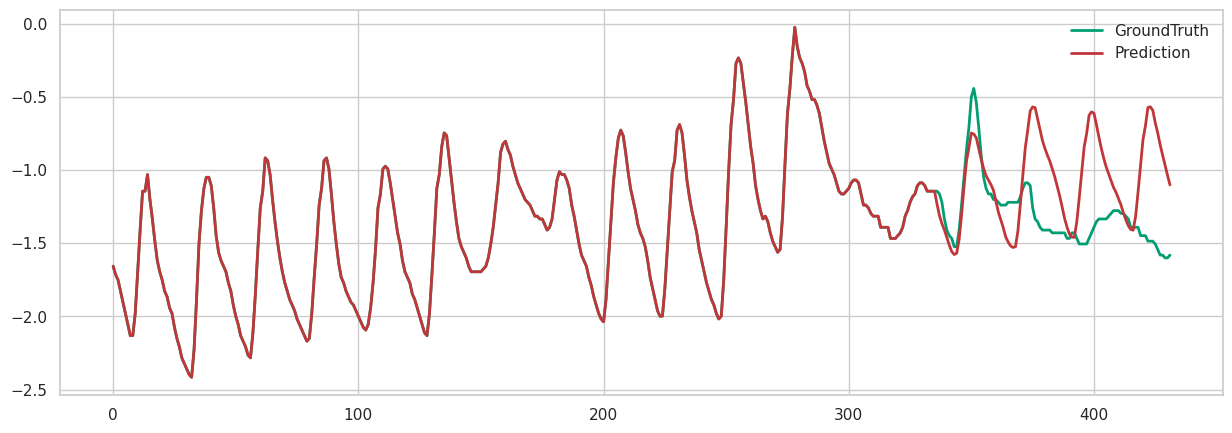

In [41]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 2: DLinear,  Prediction Length: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary

In [42]:
args.pred_len = 192 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh2_192:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 192}


### Training

In [43]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8113
                                   Training                               
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 253 	 Train Loss: 4.3603414
     Validation loss decreased (inf --> 4.360341).  Saving model ...
Updating learning rate to 0.05
                                   Epoch 2 Summery                          
--------------------------------------------------------------------------------
     Cost time: 2
     Steps: 253 	 Train Loss: 0.7815080
     Validation loss decreased (4.360341 --> 0.781508).  Saving model ...
Updating learning rate to 0.025
                                   Epoch 3 Summery                          
--------------------------------------------------------------------------------
     Cost time: 3
     Steps: 253 	 Train Loss: 0.6323317
     Validation loss decreased (0.781508 -->

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=192, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=192, bias=True)
)

### Testing

test 2689
mae:0.42713072896003723, mse:0.39656752347946167, rmse:0.629736065864563, mape:1.3307840824127197, mspe:257.22186279296875


<Figure size 1500x500 with 0 Axes>

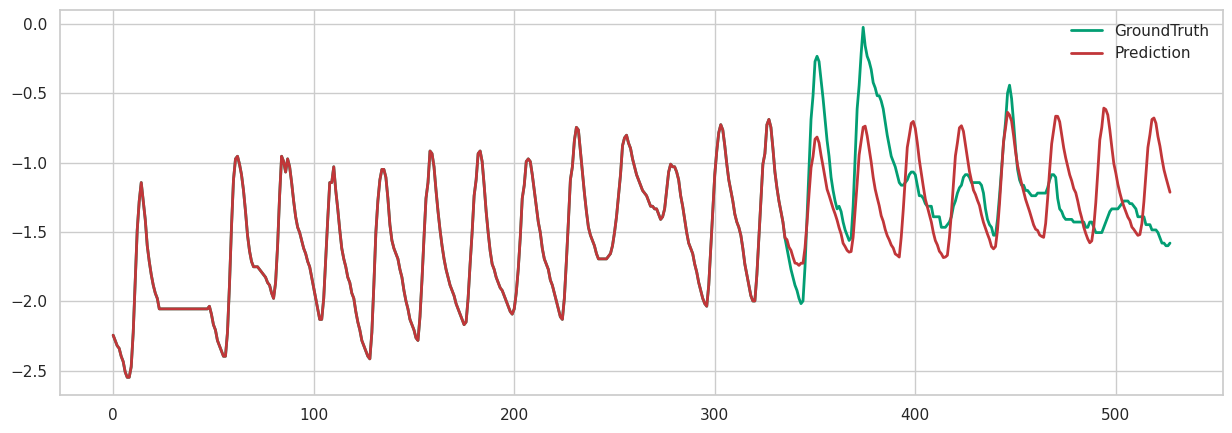

In [44]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 3: DLinear, Dataset:ETTh2,  Prediction Length: 336

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [45]:
args.pred_len = 336 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh2_336:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 336}


### Training

In [46]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7969
                                   Training                               
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 249 	 Train Loss: 4.1908200
     Validation loss decreased (inf --> 4.190820).  Saving model ...
Updating learning rate to 0.05
                                   Epoch 2 Summery                          
--------------------------------------------------------------------------------
     Cost time: 2
     Steps: 249 	 Train Loss: 0.9236629
     Validation loss decreased (4.190820 --> 0.923663).  Saving model ...
Updating learning rate to 0.025
                                   Epoch 3 Summery                          
--------------------------------------------------------------------------------
     Cost time: 3
     Steps: 249 	 Train Loss: 0.7282329
     Validation loss decreased (0.923663 -->

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=336, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=336, bias=True)
)

### Testing

test 2545
mae:0.48399868607521057, mse:0.4863511323928833, rmse:0.697388768196106, mape:1.4343116283416748, mspe:275.3100280761719


<Figure size 1500x500 with 0 Axes>

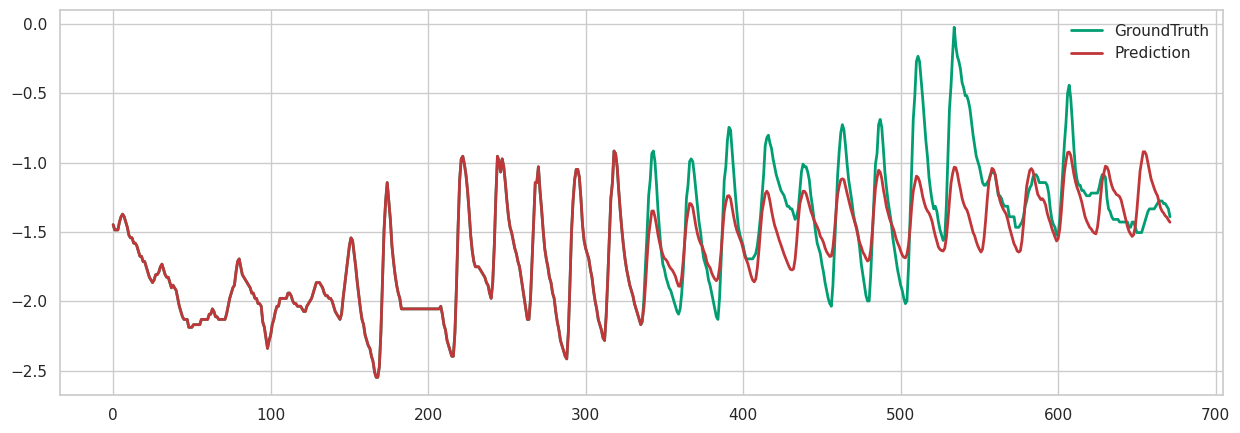

In [47]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 4: DLinear, Dataset:ETTh2,  Prediction Length: 720

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [48]:
args.pred_len = 720 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh2_720:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 720}


### Training

In [49]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7585
                                   Training                               
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 237 	 Train Loss: 3.5475819
     Validation loss decreased (inf --> 3.547582).  Saving model ...
Updating learning rate to 0.05
                                   Epoch 2 Summery                          
--------------------------------------------------------------------------------
     Cost time: 2
     Steps: 237 	 Train Loss: 1.0758589
     Validation loss decreased (3.547582 --> 1.075859).  Saving model ...
Updating learning rate to 0.025
                                   Epoch 3 Summery                          
--------------------------------------------------------------------------------
     Cost time: 3
     Steps: 237 	 Train Loss: 0.8775548
     Validation loss decreased (1.075859 -->

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=720, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=720, bias=True)
)

### Testing

test 2161
mae:0.6111089587211609, mse:0.7392709851264954, rmse:0.8598086833953857, mape:1.529211401939392, mspe:263.7061462402344


<Figure size 1500x500 with 0 Axes>

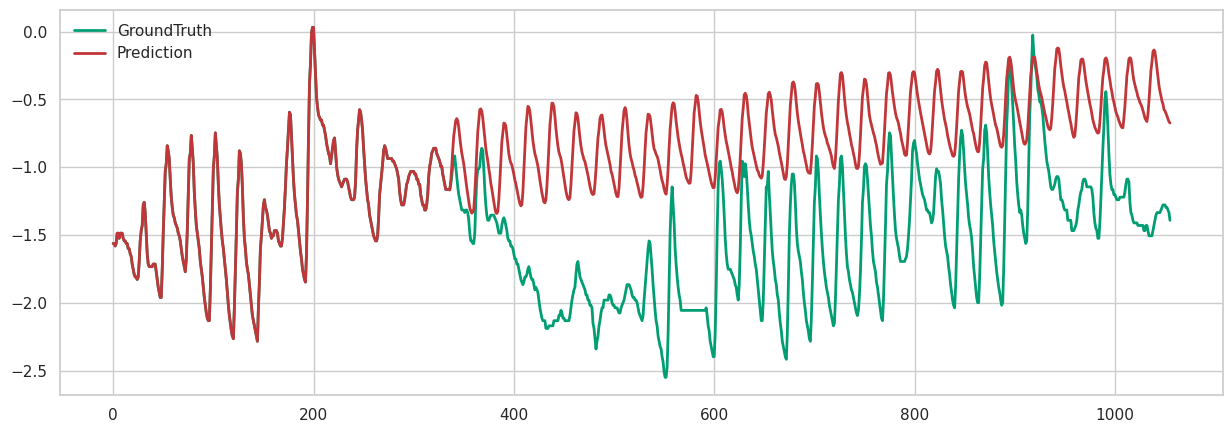

In [50]:
exp.test(setting)
torch.cuda.empty_cache()

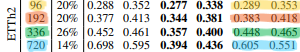

In [51]:
from IPython.display import Image
Image(filename=r"./Images/ETTh2.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 0.302042692899704 | 0.36563724279403687 |
| 192 | 0.39656752347946167 | 0.42713072896003723 |
| 336 | 0.4863511323928833| 0.48399868607521057 |
| 720 | 0.7392709851264954 | 0.6111089587211609 |

---
# Working on ETTm1 Dataset
---

## Trail 1: DLinear, Dataset:ETTm1,  Prediction Length: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [52]:
args.data_path = 'ETTm1.csv' # data file
args.data = 'ETTm1'  # data
args.pred_len = 96 # prediction sequence length

setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm1_96:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 96}


### Training

In [53]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34129
                                   Training                               
Epoch: 1, Iters: 500
--------------------------------------------------------------------------------
    Loss : 0.3942670 (MSE)
    Speed: 0.0039 sec/iter 
    Left time: 123.3997 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 1000
--------------------------------------------------------------------------------
    Loss : 0.5769948 (MSE)
    Speed: 0.0033 sec/iter 
    Left time: 100.9234 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 1066 	 Train Loss: 1.0980485
     Validation loss decreased (inf --> 1.098049).  Saving model ...
Updating learning rate to 0.05
Epoch: 2, Iters: 500
--------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=96, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=96, bias=True)
)

### Testing

test 11425
mae:0.34278151392936707, mse:0.29930633306503296, rmse:0.5470889806747437, mape:2.022235631942749, mspe:306.10418701171875


<Figure size 1500x500 with 0 Axes>

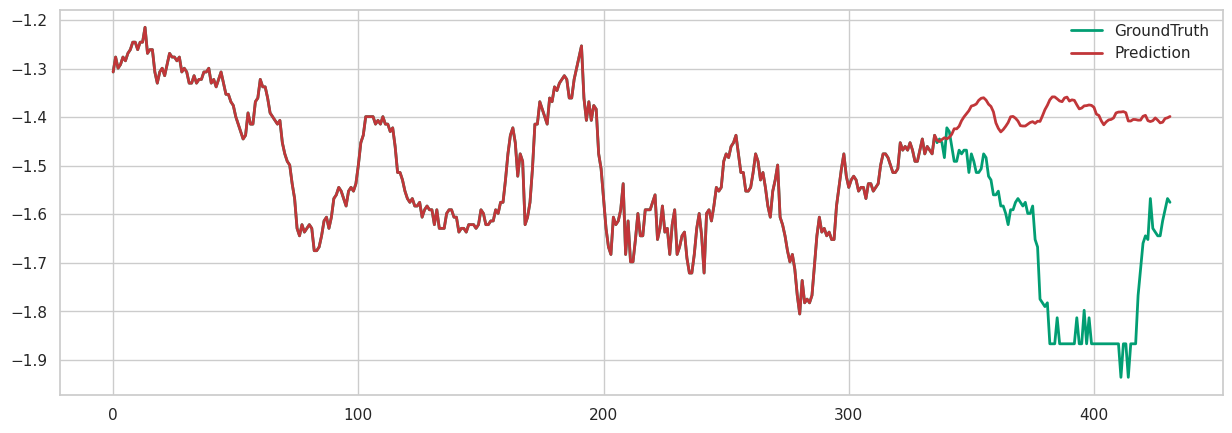

In [54]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 2: DLinear, Dataset:ETTm1 , Prediction Length: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary

In [55]:
args.pred_len = 192 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm1_192:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 192}


### Training

In [56]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34033
                                   Training                               
Epoch: 1, Iters: 500
--------------------------------------------------------------------------------
    Loss : 0.4189734 (MSE)
    Speed: 0.0033 sec/iter 
    Left time: 102.4117 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 1000
--------------------------------------------------------------------------------
    Loss : 0.5733999 (MSE)
    Speed: 0.0032 sec/iter 
    Left time: 99.9566 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 1063 	 Train Loss: 1.1072716
     Validation loss decreased (inf --> 1.107272).  Saving model ...
Updating learning rate to 0.05
Epoch: 2, Iters: 500
---------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=192, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=192, bias=True)
)

### Testing

test 11329
mae:0.36386412382125854, mse:0.3340986669063568, rmse:0.5780127048492432, mape:2.0879836082458496, mspe:328.5452880859375


<Figure size 1500x500 with 0 Axes>

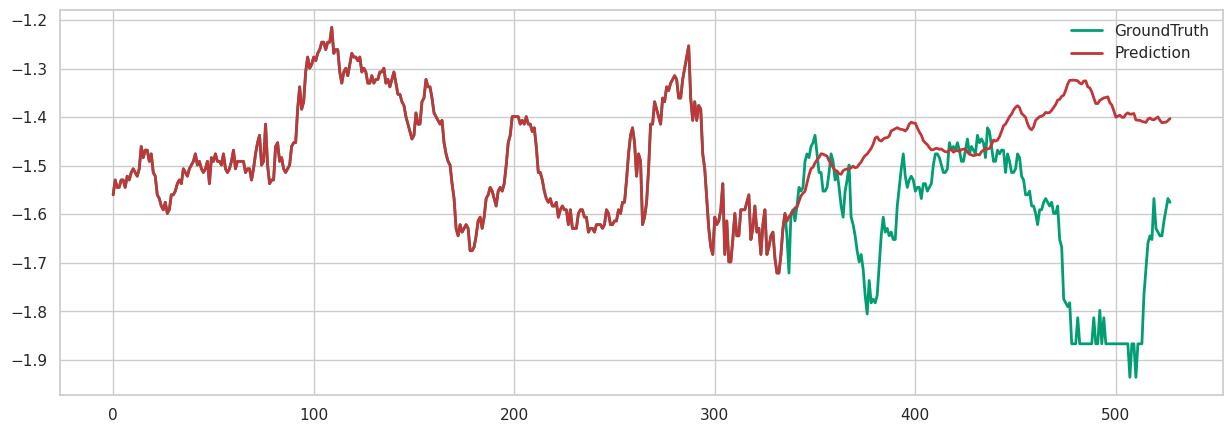

In [57]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 3: DLinear, Dataset:ETTm1,  Prediction Length: 336

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [58]:
args.pred_len = 336 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm1_336:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 336}


### Training

In [59]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33889
                                   Training                               
Epoch: 1, Iters: 500
--------------------------------------------------------------------------------
    Loss : 0.5341710 (MSE)
    Speed: 0.0035 sec/iter 
    Left time: 111.0119 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 1000
--------------------------------------------------------------------------------
    Loss : 0.6549968 (MSE)
    Speed: 0.0044 sec/iter 
    Left time: 134.0776 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 1059 	 Train Loss: 1.1834471
     Validation loss decreased (inf --> 1.183447).  Saving model ...
Updating learning rate to 0.05
Epoch: 2, Iters: 500
--------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=336, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=336, bias=True)
)

### Testing

test 11185
mae:0.3843919038772583, mse:0.3683928847312927, rmse:0.6069537997245789, mape:2.137286901473999, mspe:344.13214111328125


<Figure size 1500x500 with 0 Axes>

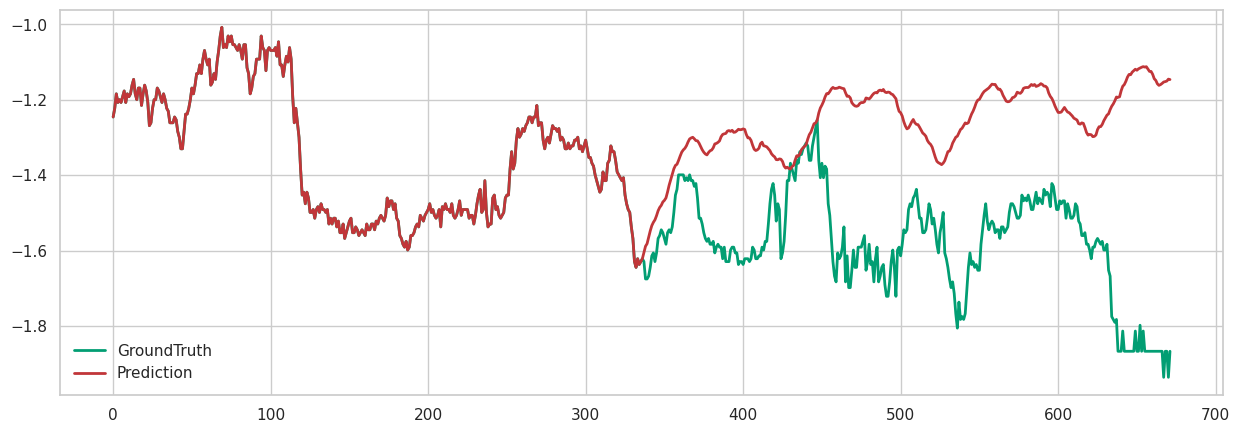

In [60]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 4: DLinear, Dataset:ETTm1,  Prediction Length: 720

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [61]:
args.pred_len = 720 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm1_720:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 720}


### Training

In [62]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33505
                                   Training                               
Epoch: 1, Iters: 500
--------------------------------------------------------------------------------
    Loss : 0.5019908 (MSE)
    Speed: 0.0039 sec/iter 
    Left time: 121.8191 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 1000
--------------------------------------------------------------------------------
    Loss : 0.7977564 (MSE)
    Speed: 0.0040 sec/iter 
    Left time: 121.3431 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 1047 	 Train Loss: 1.3947713
     Validation loss decreased (inf --> 1.394771).  Saving model ...
Updating learning rate to 0.05
Epoch: 2, Iters: 500
--------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=720, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=720, bias=True)
)

### Testing

test 10801
mae:0.41808974742889404, mse:0.42331233620643616, rmse:0.6506245732307434, mape:2.240980386734009, mspe:382.3931884765625


<Figure size 1500x500 with 0 Axes>

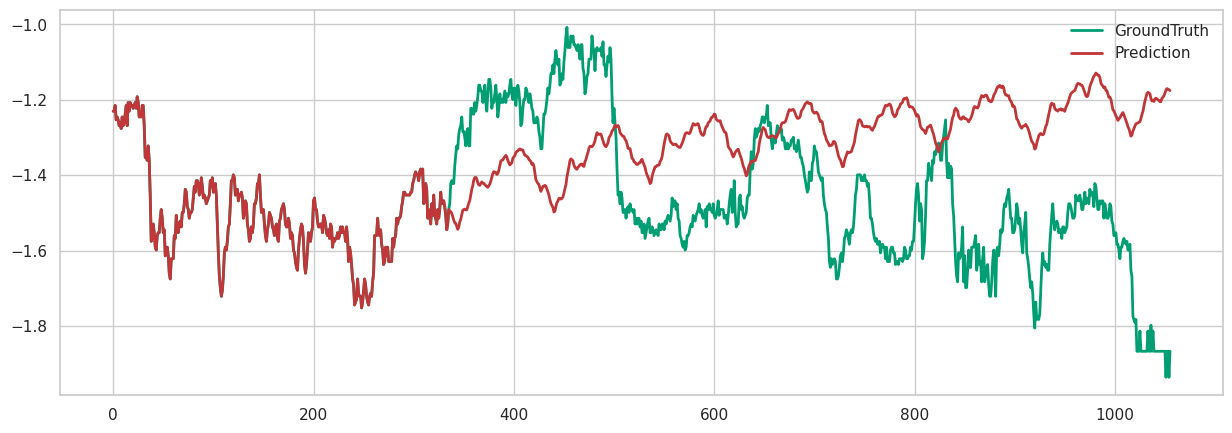

In [63]:
exp.test(setting)
torch.cuda.empty_cache()

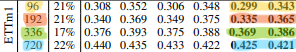

In [64]:
from IPython.display import Image
Image(filename=r"./Images/ETTm1.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 0.29958778619766235| 0.34351807832717896 |
| 192 | 0.3339731991291046 | 0.3638981282711029 |
| 336 | 0.36858290433883667 | 0.3842480182647705 |
| 720 | 0.422527939081192 | 0.4168848395347595 |

---
# Working on ETTm2 Dataset
---

## Trail 1: DLinear, Dataset:ETTm2,  Prediction Length: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [65]:
args.data_path = 'ETTm2.csv' # data file
args.data = 'ETTm2'  # data
args.pred_len = 96 # prediction sequence length

setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm2_96:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 96}


### Training

In [66]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34129
                                   Training                               
Epoch: 1, Iters: 500
--------------------------------------------------------------------------------
    Loss : 0.2146583 (MSE)
    Speed: 0.0033 sec/iter 
    Left time: 103.4398 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 1000
--------------------------------------------------------------------------------
    Loss : 0.6421894 (MSE)
    Speed: 0.0039 sec/iter 
    Left time: 120.6056 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 1066 	 Train Loss: 1.4359598
     Validation loss decreased (inf --> 1.435960).  Saving model ...
Updating learning rate to 0.05
Epoch: 2, Iters: 500
--------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=96, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=96, bias=True)
)

### Testing

test 11425
mae:0.26944929361343384, mse:0.17233557999134064, rmse:0.41513320803642273, mape:1.0335694551467896, mspe:201.26455688476562


<Figure size 1500x500 with 0 Axes>

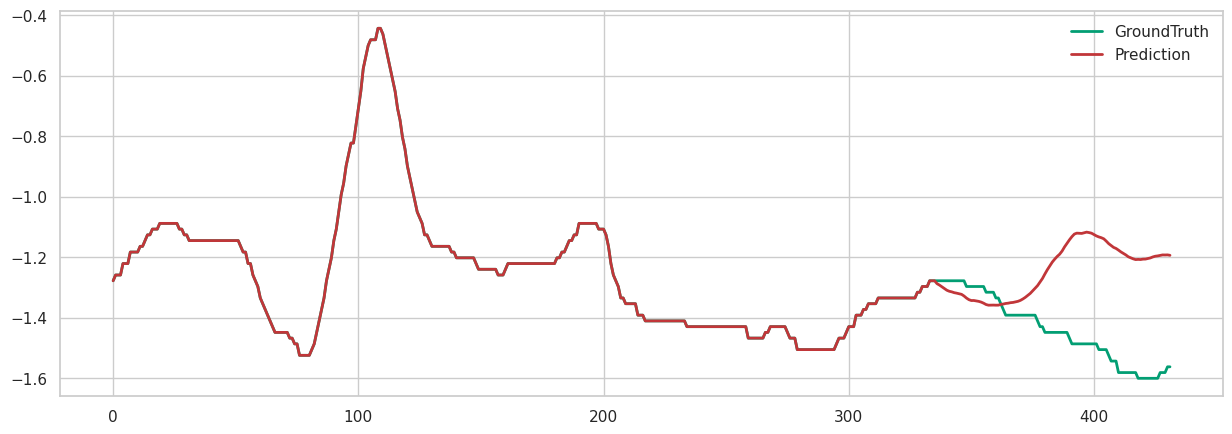

In [67]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 2: DLinear,  Prediction Length: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary

In [68]:
args.pred_len = 192 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm2_192:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 192}


### Training

In [69]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34033
                                   Training                               
Epoch: 1, Iters: 500
--------------------------------------------------------------------------------
    Loss : 0.6631716 (MSE)
    Speed: 0.0035 sec/iter 
    Left time: 108.9381 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 1000
--------------------------------------------------------------------------------
    Loss : 1.0806097 (MSE)
    Speed: 0.0033 sec/iter 
    Left time: 101.9577 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 1063 	 Train Loss: 1.5285176
     Validation loss decreased (inf --> 1.528518).  Saving model ...
Updating learning rate to 0.05
Epoch: 2, Iters: 500
--------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=192, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=192, bias=True)
)

### Testing

test 11329
mae:0.32264360785484314, mse:0.24087336659431458, rmse:0.4907885193824768, mape:1.127281904220581, mspe:206.0903778076172


<Figure size 1500x500 with 0 Axes>

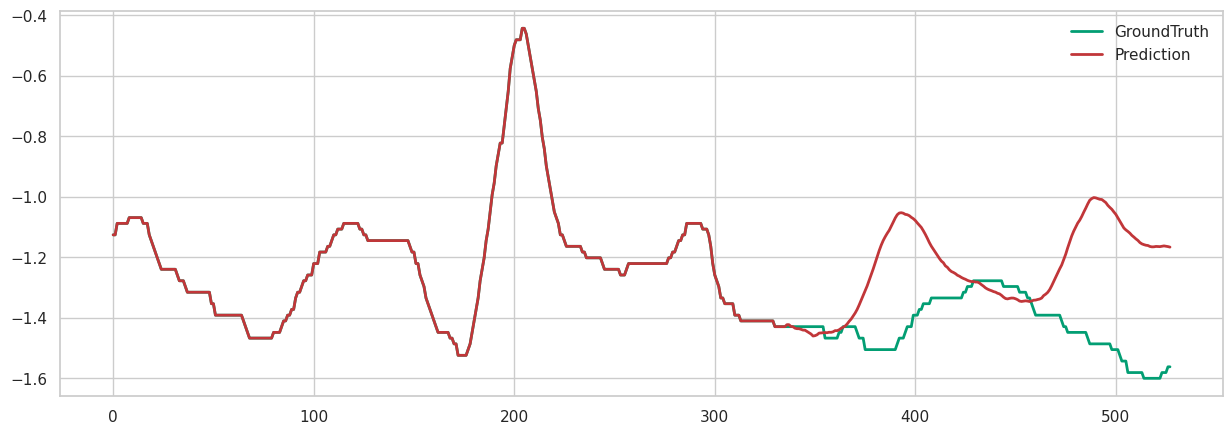

In [70]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 3: DLinear, Dataset:ETTm2,  Prediction Length: 336

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [71]:
args.pred_len = 336 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm2_336:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 336}


### Training

In [72]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33889
                                   Training                               
Epoch: 1, Iters: 500
--------------------------------------------------------------------------------
    Loss : 0.9474721 (MSE)
    Speed: 0.0038 sec/iter 
    Left time: 120.1781 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 1000
--------------------------------------------------------------------------------
    Loss : 0.7042209 (MSE)
    Speed: 0.0039 sec/iter 
    Left time: 121.1479 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 1059 	 Train Loss: 1.7067466
     Validation loss decreased (inf --> 1.706747).  Saving model ...
Updating learning rate to 0.05
Epoch: 2, Iters: 500
--------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=336, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=336, bias=True)
)

### Testing

test 11185
mae:0.3785417675971985, mse:0.3191654682159424, rmse:0.5649473071098328, mape:1.1976559162139893, mspe:208.22952270507812


<Figure size 1500x500 with 0 Axes>

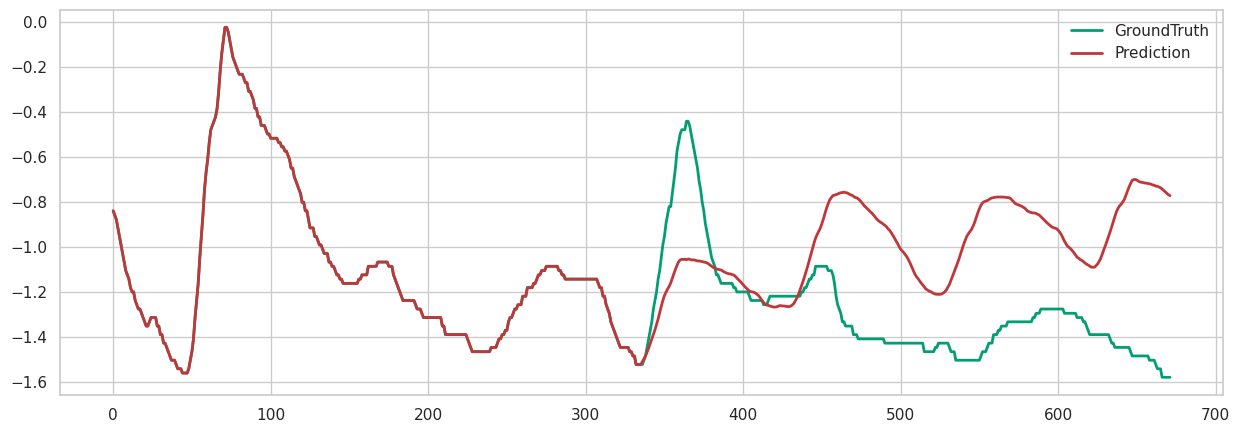

In [73]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 4: DLinear, Dataset:ETTm2,  Prediction Length: 720

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [74]:
args.pred_len = 720 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm2_720:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'train_only': True, 'train_epochs': 30, 'batch_size': 32, 'learning_rate': 0.05, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'Exp', 'itr': 1, 'model': 'DLinear', 'checkpoints': './Checkpoints/DLinear_checkpoints', 'enc_in': 7, 'label_len': 48, 'seq_len': 336, 'pred_len': 720}


### Training

In [75]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33505
                                   Training                               
Epoch: 1, Iters: 500
--------------------------------------------------------------------------------
    Loss : 0.7031286 (MSE)
    Speed: 0.0040 sec/iter 
    Left time: 123.1980 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 1000
--------------------------------------------------------------------------------
    Loss : 2.0741167 (MSE)
    Speed: 0.0038 sec/iter 
    Left time: 116.5827 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 1047 	 Train Loss: 1.9248613
     Validation loss decreased (inf --> 1.924861).  Saving model ...
Updating learning rate to 0.05
Epoch: 2, Iters: 500
--------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=720, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=720, bias=True)
)

### Testing

test 10801
mae:0.4613783061504364, mse:0.45473507046699524, rmse:0.6743404865264893, mape:1.2772231101989746, mspe:193.4087371826172


<Figure size 1500x500 with 0 Axes>

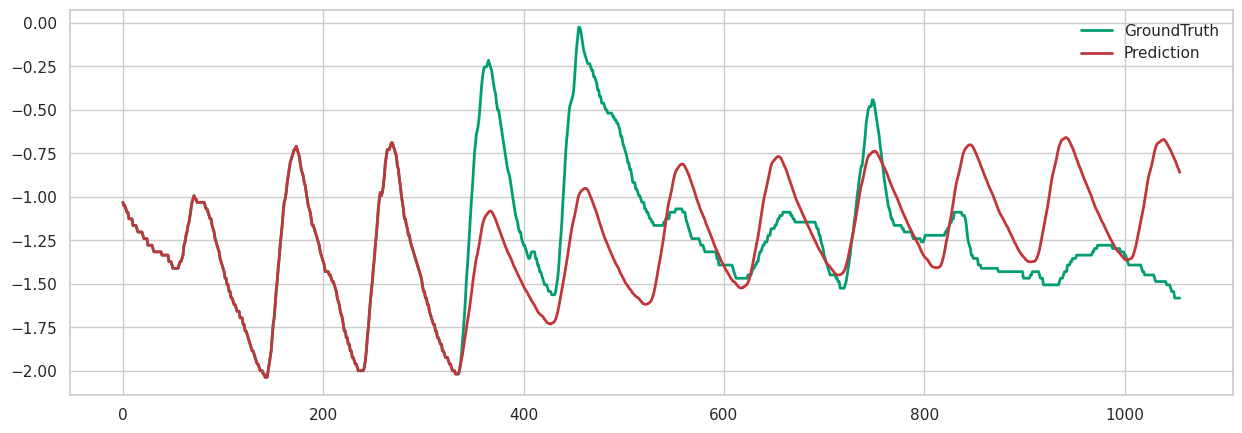

In [76]:
exp.test(setting)
torch.cuda.empty_cache()

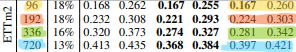

In [77]:
from IPython.display import Image
Image(filename=r"./Images/ETTm2.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 0.16786058247089386 | 0.2625715732574463 |
| 192 | 0.24425245821475983 | 0.3251453638076782 |
| 336 | 0.34370145201683044 |0.39706844091415405 |
| 720 | 0.44076594710350037 | 0.45200106501579285 |

---

In [90]:
# !zip DLinear_checkpoints.zip /kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/DLinear_checkpoints/*/*

  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/DLinear_checkpoints/DLinear_train_on_ETTh1_192/checkpoint.pth (deflated 7%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/DLinear_checkpoints/DLinear_train_on_ETTh1_336/checkpoint.pth (deflated 7%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/DLinear_checkpoints/DLinear_train_on_ETTh1_720/checkpoint.pth (deflated 7%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/DLinear_checkpoints/DLinear_train_on_ETTh1_96_test/checkpoint.pth (deflated 8%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/DLinear_checkpoints/DLinear_train_on_ETTh2_192/checkpoint.pth (deflated 7%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-serie

In [89]:
# !zip DLinear_results.zip /kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/*/*

  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/DLinear_train_on_ETTh1_192/metrics.npy (deflated 19%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/DLinear_train_on_ETTh1_192/pred.npy (deflated 8%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/DLinear_train_on_ETTh1_192/true.npy (deflated 99%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/DLinear_train_on_ETTh1_192/x.npy (deflated 99%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/DLinear_train_on_ETTh1_336/metrics.npy (deflated 19%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/DLinear_train_on_ETTh1_336/pred.npy (deflated 8%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time

In [88]:
# !zip DLinear_test_results.zip /kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/*/*

  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/DLinear_train_on_ETTh1_192/last_batch.pdf (deflated 22%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/DLinear_train_on_ETTh1_336/last_batch.pdf (deflated 19%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/DLinear_train_on_ETTh1_720/last_batch.pdf (deflated 13%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/DLinear_train_on_ETTh1_96_test/last_batch.pdf (deflated 23%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/DLinear_train_on_ETTh2_192/last_batch.pdf (deflated 23%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/DLinear_train_on_ETTh2_336/last_batch.pdf (deflated 20%)
  addi